# Training Loop

1. Retrieve the [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert) dataset. The validation dataset can be found [here](https://stanfordaimi.azurewebsites.net/datasets/23c56a0d-15de-405b-87c8-99c30138950c) contained within the CheXpert directory. Note: the test dataset provided by the researchers does not contain the same structured labels (ie: `Age`, `Sex`, etc..) as the train and validation set. We perform random sampling from the train set to retrieve the test set for this project. 
2. Generate the test set by sampling from the training set. In our case, we randomly selected 2% of the training data for testing.
3. Create the dictionaries needed to read each dataset (train, valid, test) and save them to disk. Since the training data was much too large, we create 20 separate training datasets that we iterate through when training.

See the `README.md` file in the data directory for data setup specifics.

4. Model checkpoints are made each epoch during training. Train loss, validation loss, mean AUROC during training and mean AUROC during validation are saved to a csv file each iteration.
5. The Model is trained on 20 training datasets, each representing a randomly selected 5% (without replacement) of the entire set for 10 epochs each. The batch size used was 24.


# IRENE Results

In [33]:
import pandas as pd
df_irene = pd.read_csv('checkpoints/IRENE_archive/metrics.csv')
df_irene

,dataset,set_num,epoch,trn_loss,trn_mean_auroc,val_loss,val_mean_auroc
0,./data/actual/train_0.pkl,0,1,0.563882,0.591154,0.476869,0.574488
1,./data/actual/train_0.pkl,0,2,0.548167,0.635756,0.462459,0.586174
2,./data/actual/train_0.pkl,0,3,0.539093,0.655897,0.458620,0.660027
3,./data/actual/train_0.pkl,0,4,0.525229,0.678167,0.437948,0.680434
4,./data/actual/train_0.pkl,0,5,0.519875,0.686688,0.433910,0.689004
...,...,...,...,...,...,...,...
195,./data/actual/train_19.pkl,19,6,0.406080,0.836532,0.407489,0.826824
196,./data/actual/train_19.pkl,19,7,0.403281,0.839203,0.407128,0.821158
197,./data/actual/train_19.pkl,19,8,0.401231,0.841086,0.408375,0.828896
198,./data/actual/train_19.pkl,19,9,0.399257,0.842605,0.410504,0.819801


Plotting the train and validation loss per each training iteration. Each of the 20 sets were trained for 10 epochs before moving on to the next. Each vertical dashed line represents one of the splits in the dataset.

In [44]:
import matplotlib.pyplot as plt
def plot_loss(df,title):
    plt.figure()

    # Choose a style from the available options
    plt.style.use('ggplot')

    # Plot the first line
    plt.plot(df.index, df['trn_loss'], label='Train Loss')

    # Plot the second line
    plt.plot(df.index, df['val_loss'], label='Validation Loss')

    # Add a legend
    plt.legend()

    # Add vertical lines every 10 values
    for i in range(10, len(df) + 1, 10):
        plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)


    # Add labels and title
    plt.xlabel('Iteration')
    plt.ylabel('BCE Loss')
    plt.title(title)

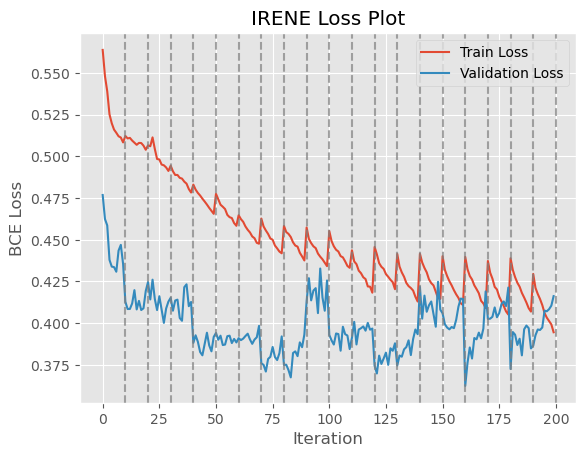

In [46]:
plot_loss(df_irene, title="IRENE Loss Plot")

Selecting the best model based on validation loss.

In [36]:
df_irene[df_irene['val_loss'] == df_irene['val_loss'].min()]

,dataset,set_num,epoch,trn_loss,trn_mean_auroc,val_loss,val_mean_auroc
160,./data/actual/train_16.pkl,16,1,0.439726,0.805184,0.36235,0.811331


The best model based on validation loss corresponds to the model saved as `set_16_epc_1.pt`.

### Predicting on Test Set

In [37]:
import torch
import matplotlib as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from torch.utils.data import DataLoader
from run_model import Data, load_pkl, item_preds, compute_auroc # import our custom data class

In [38]:
# define function to plot ROC curve
def plot_roc_curve(data_gt, data_pred, disease_name):
    '''
    Display a Single ROC Curve plot. 
    Does not call plt.figure() or plt.show() since the use of this function
    is intended to display multiple plots in one figure. 
    '''
    data_np_gt = data_gt.cpu().numpy()
    data_np_pred = data_pred.cpu().numpy()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(data_np_gt, data_np_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(disease_name)
    plt.legend(loc="lower right")

In [39]:
disease_list = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'No Finding']

def test(data_dir, tst_set, batch_size, saved_mod):
    '''
    Function for testing our saved model.
    Parameters for this function comes from the passed in args
    '''
    data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]),
    }

    num_classes = len(disease_list)

    pkl_test_dict = load_pkl(tst_set)

    # Create Train Dataset and DataLoader object
    test_data = Data(pkl_test_dict, data_dir, transform=data_transforms['test'])
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    # load a saved model
    model = torch.load(saved_mod)

    if torch.cuda.is_available():
        model.cuda()
    #optimizer_irene = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

    # Using nvidia apex for optimization
    #model, optimizer_irene = amp.initialize(model.cuda(), optimizer_irene, opt_level="O1")

    #---------------------- Begin Testing----------------------------
    model.eval()
    with torch.no_grad():

        # Initialize variables used to calculate AUROC
        outGT = torch.FloatTensor().cuda(non_blocking=True)
        outPRED = torch.FloatTensor().cuda(non_blocking=True)
        
        for item in tqdm(test_loader):
            preds, labels = item_preds(item=item, model=model)

            # probability values
            probs = torch.sigmoid(preds)

            outGT = torch.cat((outGT, labels), 0)
            outPRED = torch.cat((outPRED, probs.data), 0)
    
    # calculate AUROC
    aurocIndividual = compute_auroc(outGT, outPRED, classCount=num_classes)
    aurocMean = np.nanmean(np.array(aurocIndividual))


    # plot roc curve for each class in one 4x4 grid
    plt.figure(figsize=(16,16))
    for i in range(num_classes):
        # sub plot for each class
        plt.subplot(4, 4, i+1)
        # generate curve
        plot_roc_curve(outGT[:,i], outPRED[:,i], disease_list[i])
    plt.tight_layout()
    plt.show()
        
    # print auroc for each class
    for i in range (0, len(aurocIndividual)):
        print(disease_list[i] + ': '+str(aurocIndividual[i]))

    print('Mean AUROC:' + str(aurocMean))

100%|██████████| 182/182 [00:28<00:00,  6.46it/s]


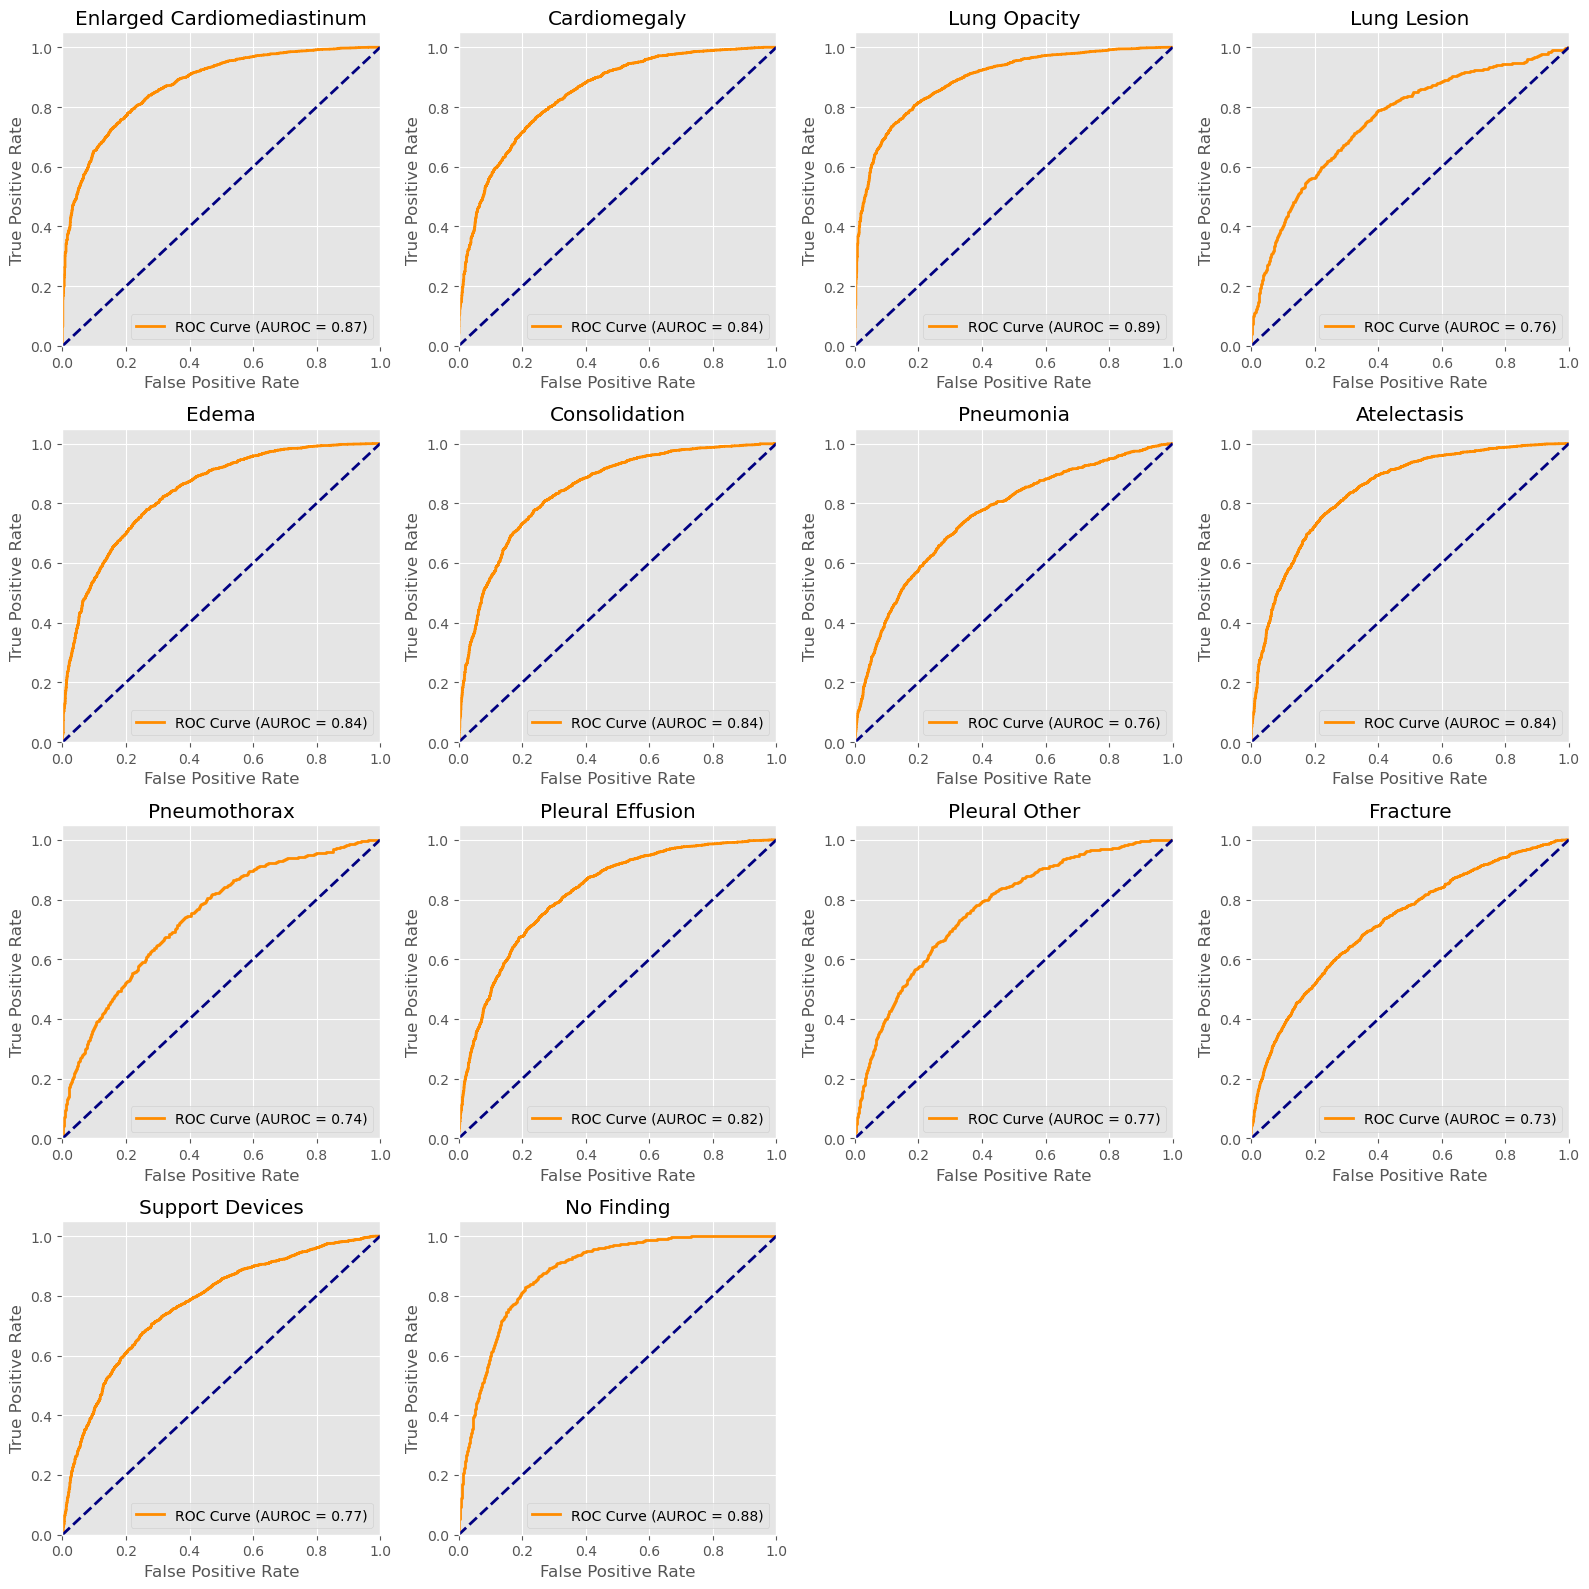

Enlarged Cardiomediastinum: 0.8743511290263744
Cardiomegaly: 0.844047914513409
Lung Opacity: 0.8917612506871662
Lung Lesion: 0.7568316376137232
Edema: 0.8391057065828638
Consolidation: 0.8446773380438695
Pneumonia: 0.7577664880054586
Atelectasis: 0.8425789546476485
Pneumothorax: 0.744931402814901
Pleural Effusion: 0.8215802859964556
Pleural Other: 0.7703854351959762
Fracture: 0.7250437388711748
Support Devices: 0.7723262789185561
No Finding: 0.8810922957730891
Mean AUROC:0.8118914183350475


In [40]:
test(data_dir="./data/actual/", tst_set="./data/actual/test_0.pkl", batch_size=24, saved_mod="./checkpoints/IRENE_archive/set_16_epc_1.pt")

# CNN

In [41]:
df_cnn = pd.read_csv('checkpoints/CNN_archive/metrics.csv')
df_cnn

,dataset,set_num,epoch,trn_loss,trn_mean_auroc,val_loss,val_mean_auroc
0,./data/actual/train_0.pkl,0,1,0.744431,0.685886,0.815908,0.695969
1,./data/actual/train_0.pkl,0,2,0.727210,0.717908,0.806534,0.687864
2,./data/actual/train_0.pkl,0,3,0.718151,0.728059,0.794475,0.682537
3,./data/actual/train_0.pkl,0,4,0.710735,0.735260,0.790883,0.685142
4,./data/actual/train_0.pkl,0,5,0.704482,0.742499,0.787876,0.691288
...,...,...,...,...,...,...,...
195,./data/actual/train_19.pkl,19,6,0.611436,0.839190,0.694304,0.781709
196,./data/actual/train_19.pkl,19,7,0.608335,0.846023,0.695937,0.776876
197,./data/actual/train_19.pkl,19,8,0.605385,0.852826,0.697169,0.779357
198,./data/actual/train_19.pkl,19,9,0.602897,0.858603,0.697330,0.785600


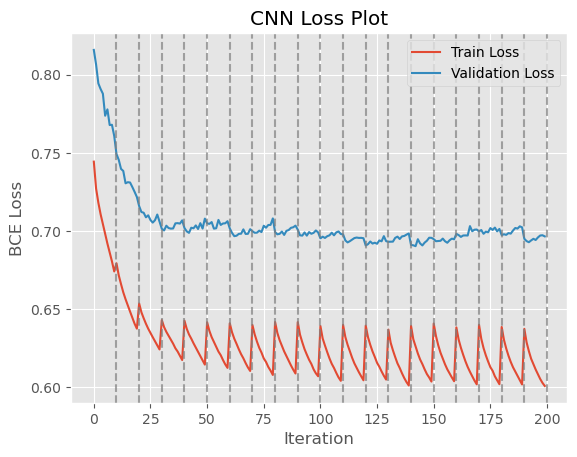

In [47]:
plot_loss(df_cnn, title="CNN Loss Plot")

In [48]:
df_cnn[df_cnn['val_loss'] == df_cnn['val_loss'].min()]

,dataset,set_num,epoch,trn_loss,trn_mean_auroc,val_loss,val_mean_auroc
142,./data/actual/train_14.pkl,14,3,0.62612,0.806226,0.690352,0.792907


100%|██████████| 182/182 [00:28<00:00,  6.47it/s]


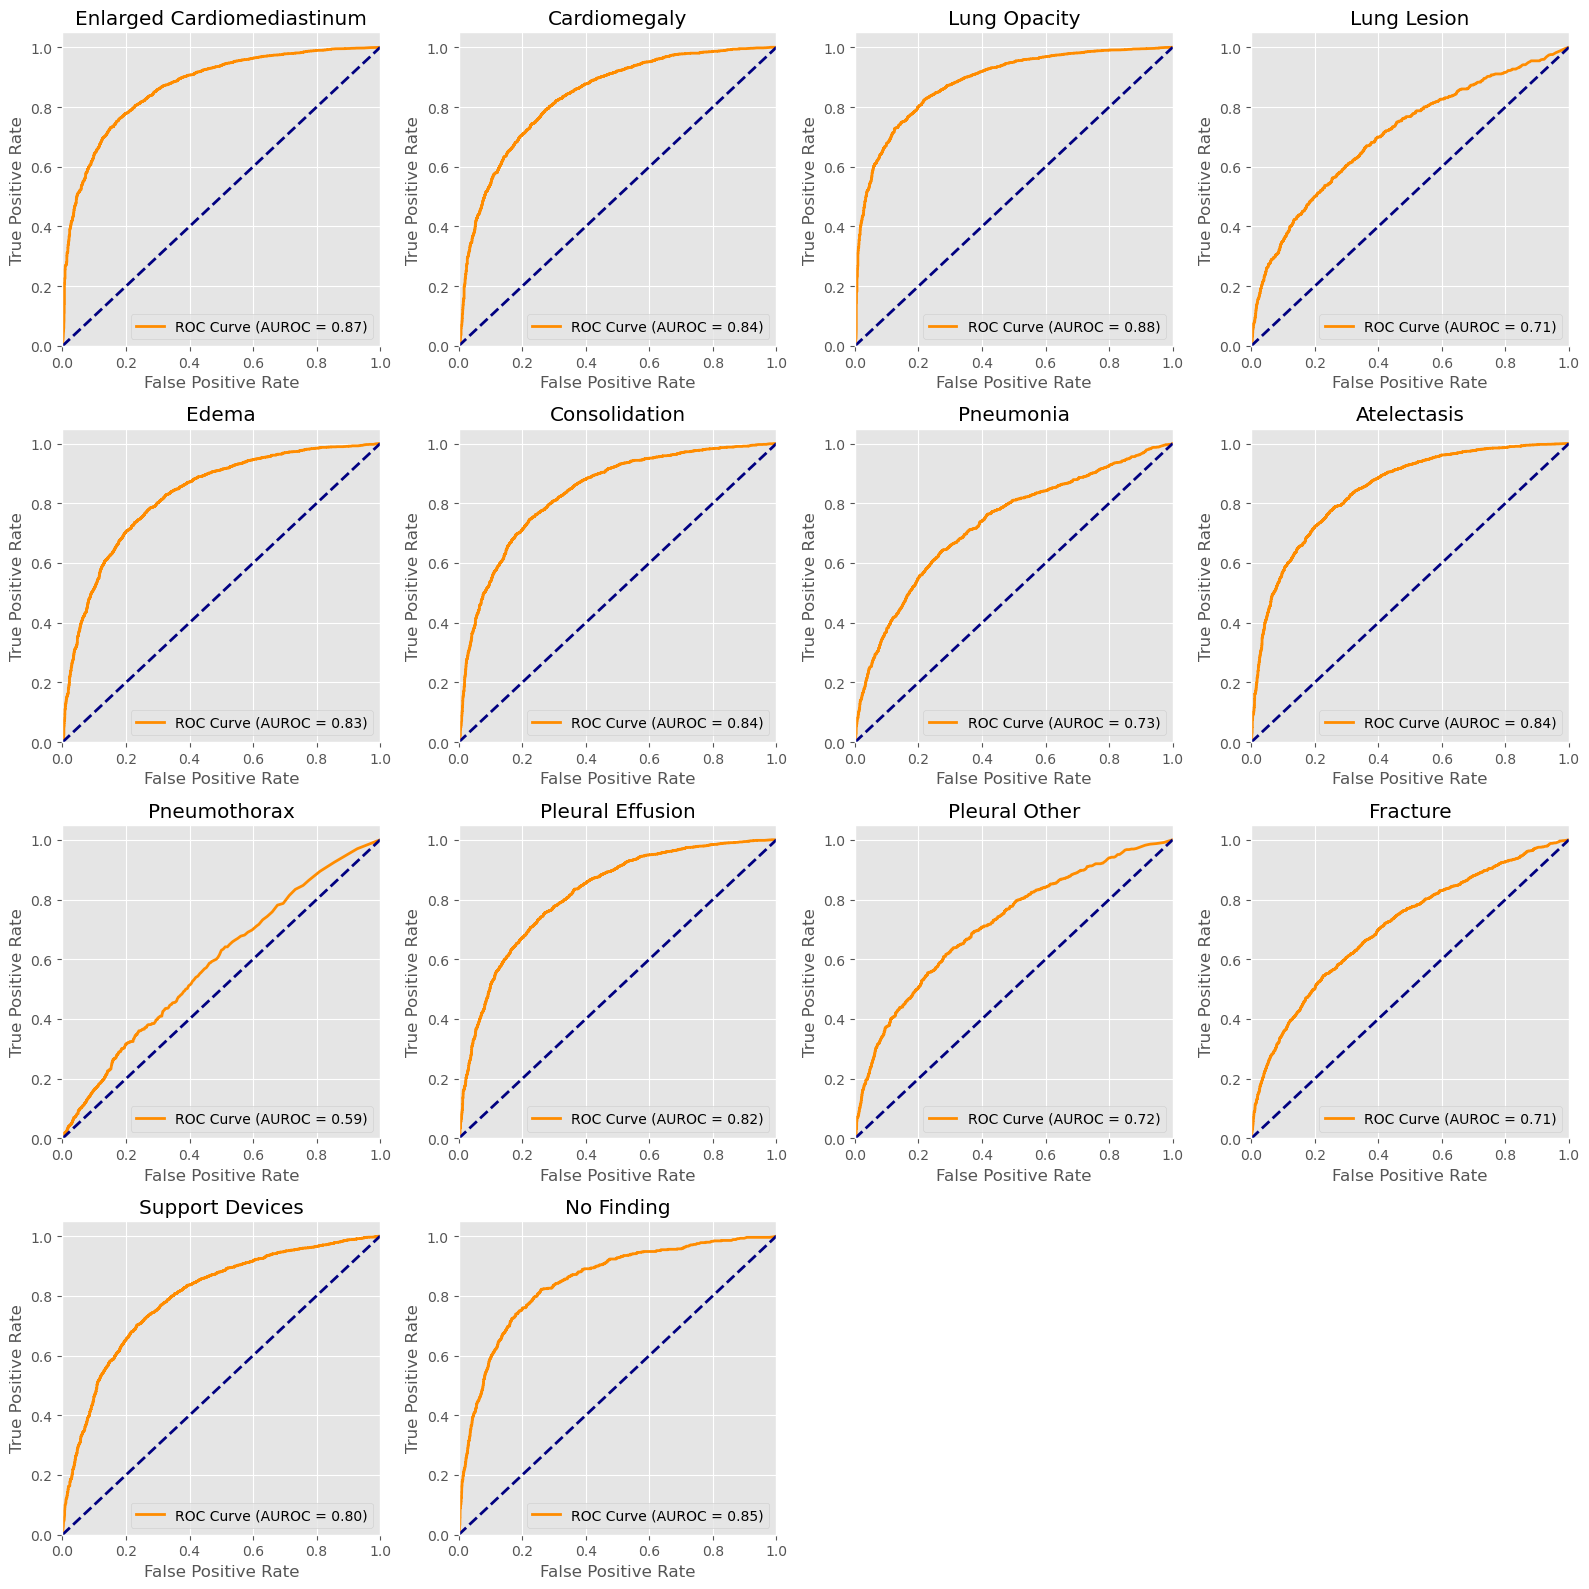

Enlarged Cardiomediastinum: 0.8707113185350017
Cardiomegaly: 0.8367842826932491
Lung Opacity: 0.8844423409172568
Lung Lesion: 0.7063461438294326
Edema: 0.8285145359807141
Consolidation: 0.8362826895176584
Pneumonia: 0.7303852831196582
Atelectasis: 0.8443586975284089
Pneumothorax: 0.5867231652348875
Pleural Effusion: 0.8189914447961903
Pleural Other: 0.7191961410476598
Fracture: 0.7091040260466273
Support Devices: 0.7978016543340439
No Finding: 0.8476949701671245
Mean AUROC:0.7869526209819938


In [32]:
# Overwrite imported functions from run_model so that we can reuse test() with our standard CNN approach.
from run_model_cnn import DataImageOnly as Data, item_preds_img_only as item_preds

test(data_dir="./data/actual/", tst_set="./data/actual/test_0.pkl", batch_size=24, saved_mod="./checkpoints/CNN_archive/set_14_epc_3.pt")

# Autoencoder

In [ ]:
df_ae = pd.read_csv('checkpoints/CNN_archive/metrics.csv')
df_ae

In [ ]:
plot_loss(df_ae, title="Autoencoder Loss Plot")

In [ ]:
df_ae[df_ae['val_loss'] == df_ae['val_loss'].min()]

Test set reconstruction loss

In [66]:
from run_model_cnn import DataImageOnly

def test_encoder(data_dir, tst_set, batch_size, saved_mod):
    '''
    Function for testing our saved model.
    Parameters for this function comes from the passed in args
    '''
    data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]),
    }

    img_dir = data_dir

    pkl_test_dict = load_pkl(tst_set)

    # Create Train Dataset and DataLoader object
    test_data = DataImageOnly(pkl_test_dict, img_dir, transform=data_transforms['test'])
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    # load a saved model
    model = torch.load(saved_mod)

    if torch.cuda.is_available():
        model.cuda()
    #optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

    # Using nvidia apex for optimization
    #model, optimizer = amp.initialize(model.cuda(), optimizer, opt_level="O1")

    # define loss function
    loss_fn = torch.nn.MSELoss()

    #---------------------- Begin Testing----------------------------
    model.eval()

    # track test loss
    test_loss = 0.0 

    with torch.no_grad():
        
        for item in tqdm(test_loader):
            inputs, _ = item
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images

            inputs = torch.FloatTensor(inputs).cuda(non_blocking=True) # convert to tensor on gpu

            # outputs
            outputs = model(inputs)

            # calculate loss
            test_loss += loss_fn(outputs, inputs).item()

    print(f"Test Loss: {test_loss:.4f} ")
    # calculate average validation loss across all batches
    test_loss /= len(test_loader)

In [ ]:
test_encoder(data_dir="./data/actual/", tst_set="./data/actual/test_0.pkl", batch_size=24, saved_mod="./checkpoints/set_0_epc_1.pt")

Comparing an input image and autoencoder output

In [90]:
from PIL import Image

def test_encoder_single(image_path, saved_mod):
    data_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])

    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    # flatten image for model and convert to tensor to use gpu
    input = data_transforms(image).unsqueeze(0)
    print(input.shape)
    input = input.view(input.size(0), -1)  # Flatten the input images
    input = torch.FloatTensor(input).cuda(non_blocking=True)

    # load a saved model
    model = torch.load(saved_mod)

    # generate output
    output = model(input)

    # define loss function
    loss_fn = torch.nn.MSELoss()

    reconstruction_loss = loss_fn(output, input).item()

    print(reconstruction_loss)


torch.Size([1, 1, 224, 224])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50176 and 150528x128)

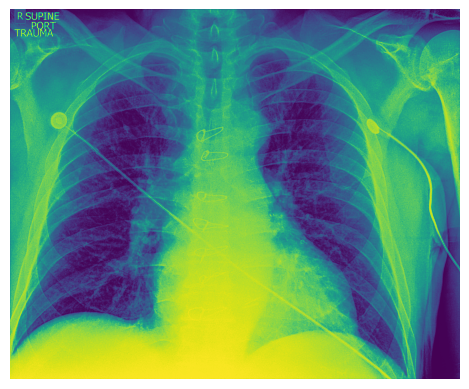

In [91]:
test_encoder_single(image_path="./data/actual/test/patient00020/study1/view1_frontal.jpg", saved_mod="./checkpoints/set_0_epc_1.pt")

# Variational Autoencoder

In [ ]:
df_vae = pd.read_csv('checkpoints/CNN_archive/metrics.csv')
df_vae

In [ ]:
plot_loss(df_vae, title="Autoencoder Loss Plot")

In [ ]:
df_vae[df_vae['val_loss'] == df_vae['val_loss'].min()]

Test set reconstruction loss

Comparing an input image and autoencoder output